# Log Semiring

[Log semirings](https://en.wikipedia.org/wiki/Log_semiring) are useful for networks of [log probabilities](https://en.wikipedia.org/wiki/Log_probability).  As small probabilities multiply, they get even smaller, pushing the limits of floating point accuracy.  In a log semiring, the natural log of the value is taken first, providing a large negative (or zero) number.  "Multiplication" in the logarithmic domain is arithmetic addition which is typically faster than multiplying.  When converted back to Python floats, the value is exponentiated to reverse the operation.

To create a new log semiring, a new type is defined that subclasses the core GraphBLAS type `FP32` (or `FP64`).  New PLUS and TIMES binary operators are defined that implement the logarithmic domain rules for adding and multiplying.  [Numba](https://numba.pydata.org/) is used to JIT compile all GraphBLAS operators defined with Python as shown here.  

Multiplication is simply the addition of the logarithmic values, addition is more complex requiring a log/exp conversion.  Since addition is a rare or unused operation in probability networks, this is usually a net performance gain over using regular floating point math.

In [1]:
from pygraphblas import *
from math import log, log1p, exp

class Log32(FP32):
    
    @binary_op(FP32)
    def PLUS(x, y):
        return x + log1p(exp(y - x))
    
    @binary_op(FP32)
    def TIMES(x, y):
        return x + y

    @classmethod
    def from_value(cls, value):
        return log(value)

    @classmethod
    def to_value(cls, data):
        return exp(data)

Insert some non-zero probabilities.  These define a graph where the weight of each edge is the probability of moving from one node to the next.

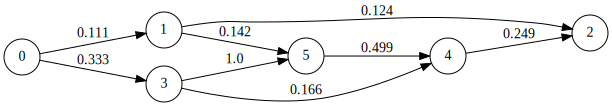

In [2]:
A = Matrix.sparse(Log32, 6, 6)
A[0,1] = 1/9.0
A[0,3] = 1/3.0
A[1,2] = 1/8.0
A[3,4] = 1/6.0
A[3,5] = 1/1.0
A[4,2] = 1/4.0
A[1,5] = 1/7.0
A[5,4] = 1/2.0
from pygraphblas.demo.gviz import draw
draw(A, label_width=5)

Now, using a custom semiring constructed from the new logarithmic domain PLUS and TIMES, multiply the graph by itself.  Internally this is done by adding logarithms, only the final result is exponetiated back into the non-zero probability.

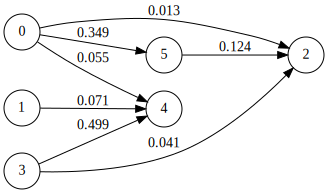

In [3]:
Log32_monoid = Log32.new_monoid(Log32.PLUS, Log32.one)
Log32_semiring = Log32.new_semiring(Log32_monoid, Log32.TIMES)

with Log32_semiring:
    d = draw(A @ A, label_width=5)
d